Section 1: Setup & Unzipping




**Purpose**

- Connect to Google Drive

- Unzip radar dataset

**Why unzip**

- Dataset stored as ZIP files to save space

- Extract to cloud server for faster access

- Reading directly from Drive is slow during training





In [ ]:
import os
import zipfile
import glob
from google.colab import drive

drive.mount('/content/drive')

# Configuration
DATASET_DIR = '/content/drive/MyDrive/RadarDataset'
EXTRACT_DIR = '/content/temp_png_data'

def unzip_png_batch(zip_path, target_dir):
    print(f"Processing {os.path.basename(zip_path)}...")
    with zipfile.ZipFile(zip_path, 'r') as z:
        # Filter for PNGs only
        png_files = [f for f in z.namelist() if f.endswith('.png')]
        z.extractall(target_dir, members=png_files)

# Cleanup & Extract
if os.path.exists(EXTRACT_DIR):
    import shutil
    shutil.rmtree(EXTRACT_DIR)
os.makedirs(EXTRACT_DIR, exist_ok=True)

zip_files = sorted(glob.glob(os.path.join(DATASET_DIR, "batch*.zip")))
print(f"Found {len(zip_files)} batches. extracting ALL...")

for z in zip_files:
    unzip_png_batch(z, EXTRACT_DIR)

print(f"✅ Extraction complete in {EXTRACT_DIR}")

Mounted at /content/drive
Found 8 batches. extracting ALL...
Processing batch1.zip...
Processing batch2.zip...
Processing batch3.zip...
Processing batch4.zip...
Processing batch5.zip...
Processing batch6.zip...
Processing batch7.zip...
Processing batch8.zip...
✅ Extraction complete in /content/temp_png_data


Section 2: File Sorting



**Purpose**

- Read filenames

- Extract timestamps (e.g., 20240903_133100)

- Sort files chronologically

**Why sorting is important**

- Radar data is time-series

- Model learns sequence of rain events

- Wrong order breaks temporal patterns

- Storm movement cannot be learned if time is mixed



In [ ]:
import re

TS_PATTERN = re.compile(r'(\d{8}_\d{6})')

def get_sorted_pngs(root_dir):
    all_files = glob.glob(os.path.join(root_dir, '**', '*.png'), recursive=True)

    valid_files = []
    for f in all_files:
        match = TS_PATTERN.search(os.path.basename(f))
        if match:
            valid_files.append((match.group(1), f))

    valid_files.sort(key=lambda x: x[0])
    return [f[1] for f in valid_files]

sorted_png_paths = get_sorted_pngs(EXTRACT_DIR)
print(f"Total PNG files found: {len(sorted_png_paths)}")

Total PNG files found: 38929


Section 3: Preprocessing

Steps

- Convert images to grayscale (1 channel)

- Resize images to 64 × 64

- Normalize pixel values (0–255 → 0.0–1.0)

Why grayscale

- Radar data represents intensity only

- Color information is unnecessary

Why resize to 64×64

- ConvLSTM processes 5D tensors

    - (Batch, Time, Height, Width, Channels)

- Full resolution → GPU memory overflow

- 64×64 preserves storm structure

- Keeps model trainable within VRAM limits

In [ ]:
import numpy as np
import cv2
from tqdm import tqdm

IMG_SIZE = (64, 64) # Resize 480x480 -> 64x64

def read_process_png(path):
    try:
        # Read as Grayscale
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None: return None

        img = cv2.resize(img, IMG_SIZE)
        img = img.astype(np.float32) / 255.0

        # Add Channel Dimension (64, 64, 1)
        return np.expand_dims(img, axis=-1)
    except:
        return None

In [ ]:
# Use ALL sorted paths
total_files = len(sorted_png_paths)
print(f"Loading ALL {total_files} images...")


Loading ALL 38929 images...


In [ ]:
data_list = []
# Loop through everything
for path in tqdm(sorted_png_paths):
    img = read_process_png(path)
    if img is not None:
        data_list.append(img)

# Shape: (Total_Samples, 64, 64, 1)
image_dataset = np.array(data_list)
print(f"✅ Final Dataset Shape: {image_dataset.shape}")

100%|██████████| 38929/38929 [03:16<00:00, 198.17it/s]


✅ Final Dataset Shape: (38929, 64, 64, 1)


Section 4: Sequence Creation & Splitting


Sequence design

- Input (X): 15 past frames (video clip)

- Target (y): 15 future frames

Difference from LSTM setup

- Same sliding window concept

- Different data shape

- LSTM input: 2D (Time, Features)

- ConvLSTM input: 5D (Samples, Time, H, W, Channels)

- Designed for video-based prediction

In [ ]:
def create_sequences(data, T_in, K_out):
    X, y = [], []
    # Sliding window
    for i in range(len(data) - T_in - K_out + 1):
        X.append(data[i : i + T_in])
        y.append(data[i + T_in : i + T_in + K_out])
    return np.array(X), np.array(y)

def get_splits(data, T, K):
    X, y = create_sequences(data, T, K)
    n = len(X)
    train_idx = int(n * 0.70)
    val_idx = int(n * 0.85)

    return (X[:train_idx], y[:train_idx],
            X[train_idx:val_idx], y[train_idx:val_idx],
            X[val_idx:], y[val_idx:])

print("Sequence logic ready.")

Sequence logic ready.


Section 5: ConvLSTM Model

Main components

- ConvLSTM2D

    - Convolution → spatial patterns

    - LSTM → temporal memory

- TimeDistributed(Conv2D)

    - Reconstructs output frame-by-frame

Why ConvLSTM

- CNN: spatial only, no time memory

- LSTM: temporal only, no spatial awareness

- ConvLSTM: learns spatio-temporal patterns

- Tracks storm shape and movement over time

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_convlstm(T, H, W, K, filters=32, kernel_size=(3,3), dropout=0.2, learning_rate=0.001, activation='tanh'):
    inp = layers.Input(shape=(T, H, W, 1))

    # Layer 1: Spatiotemporal Learning
    x = layers.ConvLSTM2D(
        filters=filters,
        kernel_size=kernel_size,
        padding='same',
        return_sequences=True, # Pass sequence to next layer
        activation=activation
    )(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)

    # Layer 2: Deeper Features
    x = layers.ConvLSTM2D(
        filters=filters,
        kernel_size=kernel_size,
        padding='same',
        return_sequences=True, # We need a sequence of K frames out
        activation='relu'
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)

    # Output Layer: Map reconstruction
    # TimeDistributed allows applying the same Conv2D to every time step
    out = layers.TimeDistributed(layers.Conv2D(
        filters=1,
        kernel_size=(1, 1), # 1x1 conv to merge filters into 1 channel
        activation='sigmoid',
        padding='same'
    ))(x)

    model = models.Model(inp, out)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Test
model_test = build_convlstm(15, 64, 64, 15)
model_test.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 15, 64, 64, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d (ConvLSTM2D)        │ (None, 15, 64, 64, 32) │        38,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 15, 64, 64, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 64, 64, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 15, 64, 64, 32) │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 15, 64, 64, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15, 64, 64, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 15, 64, 64, 1)  │            33 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,289 (438.63 KB)

 Trainable params: 112,161 (438.13 KB)

 Non-trainable params: 128 (512.00 B)

Section 6: Hyperparameter Tuning

Tested batch sizes

- 2, 4, 8

Why small batch size

- Video data is memory intensive

- Each batch contains thousands of pixels

- Larger batch sizes cause GPU OOM errors

- Batch size chosen based on GPU capacity

In [ ]:
from tensorflow.keras import callbacks
import tensorflow as tf
import gc # Garbage collector to free RAM

# 1. THE GRID (Exactly like your LSTM request)
tuning_grid = {
    "history_windows": [15],
    "forecast_horizons": [15],
    "learning_rates": [0.001, 0.005],
    "batch_sizes": [2, 4, 8],
    "dropouts": [0.2],
    "activations": ['tanh'],
    "filters": [16, 32]
}

best_val_loss = float("inf")
best_config = {}

In [ ]:
# Loop 1: Window Sizes (T)
for T in tuning_grid["history_windows"]:
    for K in tuning_grid["forecast_horizons"]:

        print(f"\n--- Preparing Data for T={T}, K={K} ---")
        # Regenerate sequences because T changed
        Xtr, Ytr, Xval, Yval, _, _ = get_splits(image_dataset, T, K)

        # Loop 2: Model Hyperparameters
        for lr in tuning_grid["learning_rates"]:
            for bs in tuning_grid["batch_sizes"]:
                for dr in tuning_grid["dropouts"]:
                    for act in tuning_grid["activations"]:
                        for flt in tuning_grid["filters"]:

                            print(f"Testing: T={T} | Batch={bs} | LR={lr} | Drop={dr} ...", end=" ")

                            try:
                                # Build Model
                                model = build_convlstm(T, 64, 64, K,
                                                       filters=flt,
                                                       dropout=dr,
                                                       learning_rate=lr) # removed activation param if not in build func, or add it
                                # Note: Ensure build_convlstm accepts 'activation' or hardcode 'tanh'

                                # Early Stop
                                early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

                                # Train
                                history = model.fit(
                                    Xtr, Ytr,
                                    validation_data=(Xval, Yval),
                                    epochs=5,       # Keep low for tuning
                                    batch_size=bs,
                                    callbacks=[early_stop],
                                    verbose=0       # Silent
                                )

                                # Result
                                val_loss = min(history.history['val_loss'])
                                print(f"-> Loss: {val_loss:.5f}")

                                if val_loss < best_val_loss:
                                    best_val_loss = val_loss
                                    best_config = {
                                        "T": T, "K": K, "lr": lr, "batch": bs,
                                        "dropout": dr, "activation": act,
                                        "filters": flt, "val_loss": val_loss
                                    }
                                    print(f"   🌟 NEW BEST FOUND!")

                            except Exception as e:
                                print(f"\n   ⚠️ SKIPPED (OOM/Error): Batch {bs} too large for T={T}")
                                # Force clear memory
                                tf.keras.backend.clear_session()
                                gc.collect()

                            # Cleanup after every run
                            if 'model' in locals(): del model
                            tf.keras.backend.clear_session()
                            gc.collect()

print("\n" + "="*30)
print("TUNING COMPLETE")
print("Best Configuration:")
print(best_config)


--- Preparing Data for T=15, K=15 ---
Testing: T=15 | Batch=2 | LR=0.001 | Drop=0.2 ... -> Loss: 0.01987
   🌟 NEW BEST FOUND!
Testing: T=15 | Batch=2 | LR=0.001 | Drop=0.2 ... -> Loss: 0.01983
   🌟 NEW BEST FOUND!
Testing: T=15 | Batch=4 | LR=0.001 | Drop=0.2 ... -> Loss: 0.01969
   🌟 NEW BEST FOUND!
Testing: T=15 | Batch=4 | LR=0.001 | Drop=0.2 ... -> Loss: 0.01942
   🌟 NEW BEST FOUND!
Testing: T=15 | Batch=8 | LR=0.001 | Drop=0.2 ... -> Loss: 0.01963
Testing: T=15 | Batch=8 | LR=0.001 | Drop=0.2 ... -> Loss: 0.01913
   🌟 NEW BEST FOUND!
Testing: T=15 | Batch=2 | LR=0.005 | Drop=0.2 ... -> Loss: 0.01942
Testing: T=15 | Batch=2 | LR=0.005 | Drop=0.2 ... -> Loss: 0.01927
Testing: T=15 | Batch=4 | LR=0.005 | Drop=0.2 ... -> Loss: 0.01946
Testing: T=15 | Batch=4 | LR=0.005 | Drop=0.2 ... -> Loss: 0.01919
Testing: T=15 | Batch=8 | LR=0.005 | Drop=0.2 ... -> Loss: 0.01938
Testing: T=15 | Batch=8 | LR=0.005 | Drop=0.2 ... -> Loss: 0.01902
   🌟 NEW BEST FOUND!

TUNING COMPLETE
Best Configura

Section 7: Save Best Configs

What is saved

- Best hyperparameters

- Stored in .json file

Why save

- Ensures reproducibility

- Avoids manual reconfiguration

- Allows exact model reconstruction

In [ ]:
import json
import numpy as np

if best_config:
    safe_config = {k: (int(v) if isinstance(v, (np.int64, np.int32)) else v) for k, v in best_config.items()}
    with open("best_convlstm_config.json", "w") as f:
        json.dump(safe_config, f)
    print("Config Saved.")

Config Saved.


Section 8: Reconstruct Best Models with Optimal Hyperparameters

Steps

- Reload best parameters

- Train model for 20 epochs

- Use combined Train + Validation data

Why retrain

- Grid search = quick experiments

- Final training maximizes performance

- Prepare model before testing

In [ ]:
with open("best_convlstm_config.json", "r") as f:
    opt = json.load(f)

In [ ]:
Xtr, Ytr, Xval, Yval, Xte, Yte = get_splits(image_dataset, opt["T"], opt["K"])
X_final = np.concatenate([Xtr, Xval])
Y_final = np.concatenate([Ytr, Yval])

final_model = build_convlstm(opt["T"], 64, 64, opt["K"], filters=opt["filters"], dropout=opt["dropout"], learning_rate=opt["lr"])

print("Training Final Model...")
history = final_model.fit(
    X_final, Y_final,
    epochs=15, # Increase for real results
    batch_size=opt["batch"],
    validation_split=0.1,
    callbacks=[callbacks.EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=1
)

Training Final Model...
Epoch 1/15
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 188s 48ms/step - loss: 0.0369 - mae: 0.1020 - val_loss: 0.0268 - val_mae: 0.0535
Epoch 2/15
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 167s 45ms/step - loss: 0.0212 - mae: 0.0514 - val_loss: 0.0232 - val_mae: 0.0521
Epoch 3/15
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 167s 45ms/step - loss: 0.0204 - mae: 0.0474 - val_loss: 0.0228 - val_mae: 0.0520
Epoch 4/15
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 168s 45ms/step - loss: 0.0198 - mae: 0.0456 - val_loss: 0.0229 - val_mae: 0.0503
Epoch 5/15
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 170s 46ms/step - loss: 0.0197 - mae: 0.0455 - val_loss: 0.0235 - val_mae: 0.0527
Epoch 6/15
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 170s 46ms/step - loss: 0.0196 - mae: 0.0453 - val_loss: 0.0227 - val_mae: 0.0502
Epoch 7/15
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 168s 45ms/step - loss: 0.0199 - mae: 0.0458 - val_loss: 0.0232 - val_mae: 0.0505
Epoch 8/15
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 168s 45ms/step - loss: 0.0198 - mae: 0.0458 - val_loss: 0.0228 - val_mae:

Section 9: Training + Validation Loss Curves

In [ ]:
import matplotlib.pyplot as plt

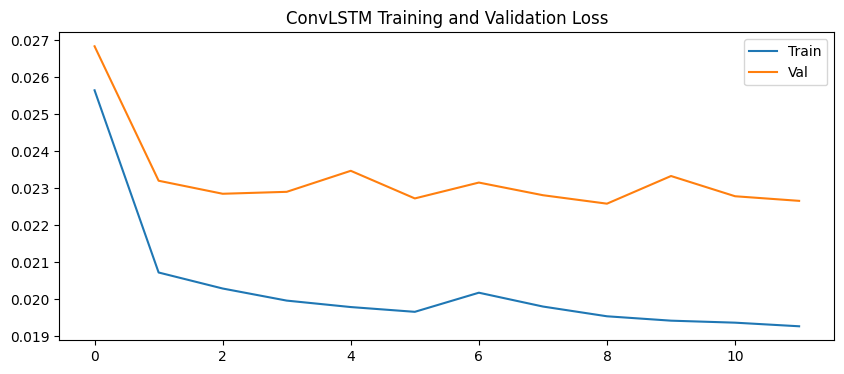

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("ConvLSTM Training and Validation Loss")
plt.legend()
plt.show()

Section 10: Evaluation ConvLSTM (RMSE & MAE)

Evaluation methods

- RMSE = 0.1497

- Pixel-wise comparison

- Heatmap visualization (Actual vs Predicted)

Why RMSE is higher than LSTM

- Predicts entire image (4096 pixels)

- More complex task than scalar prediction

Model strength

- Captures storm movement and location

- Preserves spatial structure

- Trades numerical precision for spatial awareness

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("Evaluating on Test Set...")
y_pred = final_model.predict(Xte)

# Flatten for metrics
y_true_flat = Yte.reshape(-1)
y_pred_flat = y_pred.reshape(-1)

rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
mae = mean_absolute_error(y_true_flat, y_pred_flat)

print("\n" + "="*30)
print("FINAL TEST SCORES")
print("="*30)
print(f"RMSE (Root Mean Sq Error): {rmse:.4f}")
print(f"MAE  (Mean Absolute Error): {mae:.4f}")
print("="*30)

Evaluating on Test Set...
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step

FINAL TEST SCORES
RMSE (Root Mean Sq Error): 0.1497
MAE  (Mean Absolute Error): 0.0487


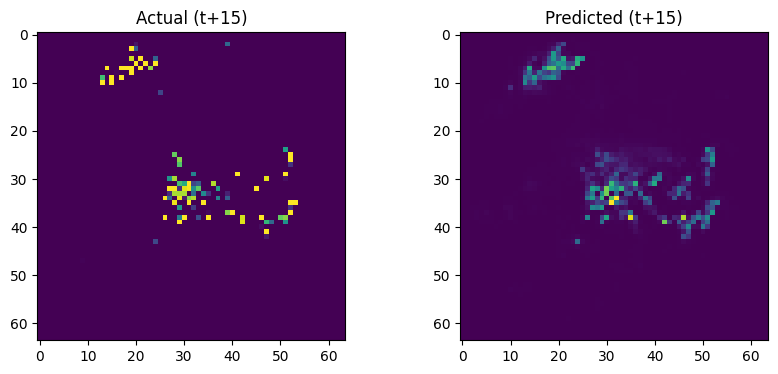

In [ ]:
# Visual comparison for one sample
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(Yte[0, 14, :, :, 0]); plt.title("Actual (t+15)")
plt.subplot(1,2,2); plt.imshow(y_pred[0, 14, :, :, 0]); plt.title("Predicted (t+15)")
plt.show()